# TD3 W/ AI GYM PENDULUM

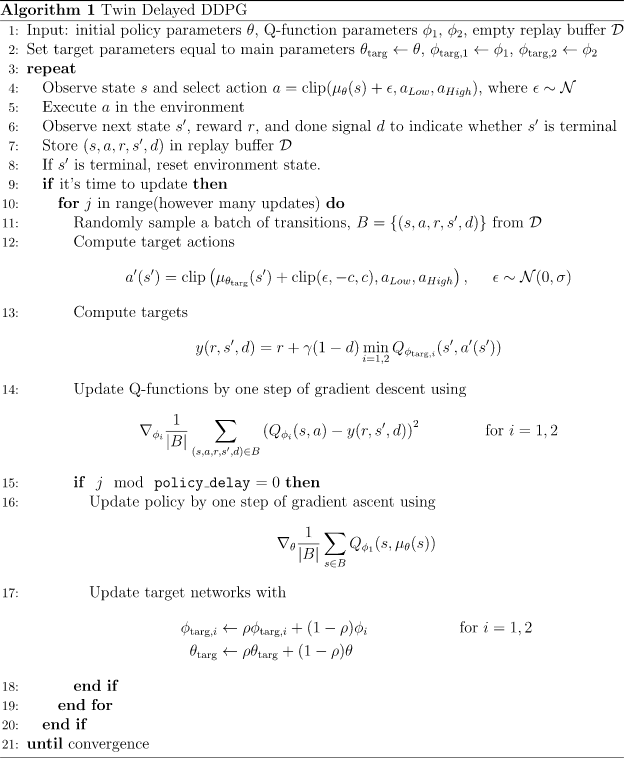

https://spinningup.openai.com/en/latest/algorithms/td3.html


In [1]:
import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)   
    
    def get_noise_vector(self, actions):
        "use noise level set already on each action"
        noise_vec = torch.clip(torch.tensor(np.array([self.evolve_state() for i in range(len(actions))])), 
                               self.min_sigma/2, 
                               self.max_sigma/2)
        return (torch.clip(actions + noise_vec,
                           self.low[0],
                           self.high[0])).to(torch.float32)
        

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.autograd
from torch.autograd import Variable

class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, learning_rate = 3e-4):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x



In [3]:
import torch
import torch.autograd
import torch.optim as optim
import torch.nn as nn


class TD3agent:
    def __init__(self, 
                 env, 
                 hidden_size=256, 
                 actor_learning_rate=1e-4, 
                 critic_learning_rate=1e-3, 
                 gamma=0.99, tau=1e-2, 
                 max_memory_size=50000):
        
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor = Actor(self.num_states, hidden_size, self.num_actions)
        self.actor_target = Actor(self.num_states, hidden_size, self.num_actions)
        self.critic1 = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target1 = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic2 = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target2 = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)        
        
        #copy params
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.critic_target2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(param.data)
            
        #init noise
        self.noise = OUNoise(env.action_space)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_criterion1  = nn.MSELoss()
        self.critic_criterion2  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer1 = optim.Adam(self.critic1.parameters(), lr=critic_learning_rate)
        self.critic_optimizer2 = optim.Adam(self.critic2.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state, step):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return self.noise.get_action(action, step)
    
    def update(self, batch_size, actor_update = False):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states = torch.FloatTensor(np.array(states))
        actions = torch.FloatTensor(np.array(actions))
        rewards = torch.FloatTensor(np.array(rewards))
        next_states = torch.FloatTensor(np.array(next_states))
    
        # Critic loss  
        # get Qvals
        Qvals1 = self.critic1.forward(states, actions)
        Qvals2 = self.critic2.forward(states, actions)
               
        #get next actions from actor
        #add some minimal noise for policy smoothing
        next_actions = self.noise.get_noise_vector(self.actor_target.forward(next_states))
        #get next action values from critic target
        next_Q1 = self.critic_target1.forward(next_states, next_actions.detach())
        next_Q2 = self.critic_target2.forward(next_states, next_actions.detach())
        #take min of next q
        min_tensor = torch.stack((next_Q1, next_Q2), dim = 0)
        min_tensor = min_tensor.min(axis = 0).values       
        #calculate q prime (used in critic loss)
        Qprime1 = rewards + self.gamma * min_tensor
        Qprime2 = Qprime1.clone().detach()      
        
        #calc loss btw Qvals and Qprime
        critic_loss1 = self.critic_criterion1(Qvals1, Qprime1)
        critic_loss2 = self.critic_criterion2(Qvals2, Qprime2)

        # Actor loss and update
        if actor_update:
            policy_loss = -self.critic1.forward(states, self.actor.forward(states)).mean()

            # update actor networks
            self.actor_optimizer.zero_grad()
            policy_loss.backward()        
            self.actor_optimizer.step()
            
            # soft update target actor networks 
            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

        #update critic networks
        self.critic_optimizer1.zero_grad()
        critic_loss1.backward() 
        self.critic_optimizer1.step()
        
        self.critic_optimizer2.zero_grad()
        critic_loss2.backward() 
        self.critic_optimizer2.step()        

        # soft update critic target networks 
     
        for target_param, param in zip(self.critic_target1.parameters(), self.critic1.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            
        for target_param, param in zip(self.critic_target2.parameters(), self.critic2.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
            

episode: 0, reward: -3400.78, average _reward: -3400.778734955083
episode: 1, reward: -4181.38, average _reward: -3791.0816590325367
episode: 2, reward: -3074.89, average _reward: -3552.35225461435
episode: 3, reward: -2356.43, average _reward: -3253.37114301314
episode: 4, reward: -1127.59, average _reward: -2828.214372260414
episode: 5, reward: -763.18, average _reward: -2484.041589672814
episode: 6, reward: -127.95, average _reward: -2147.457172934834
episode: 7, reward: -242.92, average _reward: -1909.3905176052183
episode: 8, reward: -253.72, average _reward: -1725.4268251699914
episode: 9, reward: -249.46, average _reward: -1577.829683850157
episode: 10, reward: -240.46, average _reward: -1261.7975518170135
episode: 11, reward: -241.61, average _reward: -867.8200372698544
episode: 12, reward: -489.95, average _reward: -609.3260599512304
episode: 13, reward: -380.77, average _reward: -411.7607754421175
episode: 14, reward: -4.08, average _reward: -299.40998490712593
episode: 15, r

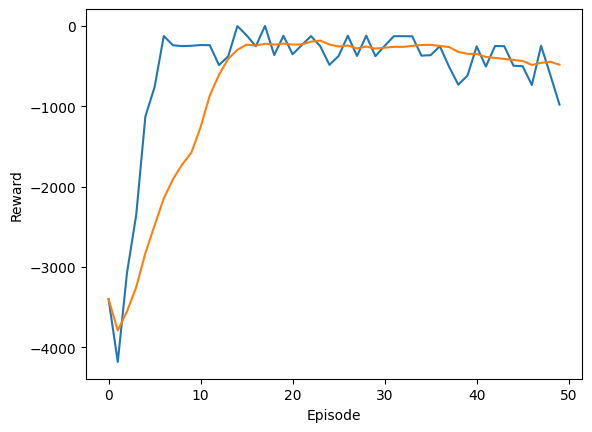

In [4]:
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env = gym.make("Pendulum-v1")

agent = TD3agent(env)
batch_size = 128
rewards = []
avg_rewards = []
total_steps = 0
actor_update_steps = 2

for episode in range(50):
    state = env.reset()[0]
    agent.noise.reset()
    episode_reward = 0
    
    for step in range(500):

        action = agent.get_action(state, step)
        new_state, reward, done, trunc, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            if total_steps%actor_update_steps == 0:
                agent.update(batch_size, actor_update = True)  
            else:
                agent.update(batch_size) 
                
        state = new_state
        episode_reward += reward

        if done or step>=499:
            rewards.append(episode_reward)
            avg_rewards.append(np.mean(rewards[-10:]))
            print("episode: {}, reward: {}, average _reward: {}".format(episode, 
                                                                        np.round(episode_reward, decimals=2),
                                                                        np.mean(rewards[-10:])))            
            break

    

plt.plot(rewards)
plt.plot(avg_rewards)
plt.plot()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
